# Preparacion de los datos

En este cuadernillo se van a extraer los datos de los dataset, se van atratar y se van a volver a guardar para ser usados en otros cuadernillos.

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
input_path = "Input/"
dataset_name = "cifar-10"

## Funciones

Funcion para extraer los datos de los ficheros

In [3]:
# https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin')
    return dict

Funcion Para el guardado de un set de datos

In [4]:
def saveDataset(dataset, name):
    savefile = input_path+dataset_name+"-"+name
    if os.path.isfile(savefile):
        print("Este set ya esta preparado")
    else:
        pickle.dump(dataset, open(savefile, "wb"))

Funcion para comprobar la correcta carga de un set de datos

In [5]:
def tryDataset(dataset):
    print(dataset["data"].shape)
    #plt.figure()
    f, arrx = plt.subplots(1,2)
    i = np.random.randint(0,dataset["data"].shape[0])
    arrx[0].imshow(dataset["data"][i])
    arrx[0].set_title(dataset["labels"][i])
    i = np.random.randint(0,dataset["data"].shape[0])
    arrx[1].imshow(dataset["data"][i])
    arrx[1].set_title(dataset["labels"][i])
    for a in arrx:
        a.axis("off")
    plt.show()
    plt.close()


## Carga y guardado

### Conjunto de entrenamiento

Extraemos los datos del fichero.

In [6]:
batch1 = unpickle("Input/cifar-10-batches-py/data_batch_1")
batch2 = unpickle("Input/cifar-10-batches-py/data_batch_2")
batch3 = unpickle("Input/cifar-10-batches-py/data_batch_3")
batch4 = unpickle("Input/cifar-10-batches-py/data_batch_4")
batch5 = unpickle("Input/cifar-10-batches-py/data_batch_5")

En cifar10 los datos estan almacenados en un diccionario que contiene el nombre del lote, las etiquetas para clasificacion, los datos (imagenes) y los nombres de fichero correspondientes.

In [7]:
print(batch1.keys())
for i in batch1:
    print(i, type(batch1[i]))

dict_keys(['batch_label', 'labels', 'data', 'filenames'])
batch_label <class 'str'>
labels <class 'list'>
data <class 'numpy.ndarray'>
filenames <class 'list'>


Las imagenes vienen en el modo ``channelsfirst``, en este modo, tenemos 3 matrices de la dimension de la imagen, una para cada canal. Muchas de las funciones admiten por defecto el modo ``chanelslast`` en el que tenemos una matriz de la dimension de la imagen y cada posicion tiene un vector con los codigos de color de cada punto.

Por simplicidad, como paso de preprocesamiento, voy a transformar las imagenes de ``channelsfirst`` a ``channelslast``.

In [8]:
# https://www.binarystudy.com/2021/09/how-to-load-preprocess-visualize-CIFAR-10-and-CIFAR-100.html
imagen = batch1["data"][0]
imagen = imagen.reshape(3,32,32)
imagen=imagen.transpose(1,2,0)
print(imagen.shape)

(32, 32, 3)


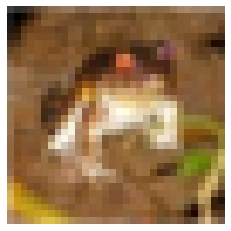

In [9]:
plt.imshow(imagen)
plt.axis("off")
del imagen

Cargamos todas las imagenes de entrenamiento en la variable ``X_train`` y borramos todo lo demás, excepto las etiquetas, ya que no lo vamos a utilizar.

In [10]:
print(batch1["data"].shape)
X_train = {}
X_train["data"] = batch1["data"].reshape(10000, 3, 32, 32)
X_train["labels"] = batch1["labels"]
del batch1
X_train["data"] = np.concatenate((X_train["data"], batch2["data"].reshape(10000, 3, 32, 32)))
X_train["labels"] = np.concatenate((X_train["labels"], batch2["labels"]))
del batch2
X_train["data"] = np.concatenate((X_train["data"], batch3["data"].reshape(10000, 3, 32, 32)))
X_train["labels"] = np.concatenate((X_train["labels"], batch3["labels"]))
del batch3
X_train["data"] = np.concatenate((X_train["data"], batch4["data"].reshape(10000, 3, 32, 32)))
X_train["labels"] = np.concatenate((X_train["labels"], batch4["labels"]))
del batch4
X_train["data"] = np.concatenate((X_train["data"], batch5["data"].reshape(10000, 3, 32, 32)))
X_train["labels"] = np.concatenate((X_train["labels"], batch5["labels"]))
del batch5
X_train["data"] = X_train["data"].transpose(0,2,3,1)
X_train["data"]=X_train["data"]/255

(10000, 3072)


Probamos el set de datos

(50000, 32, 32, 3)


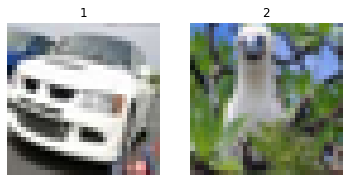

In [11]:
tryDataset(X_train)

Guardamos el set de datos en el almacenamiento y lo borramos de la memoria

In [12]:
saveDataset(X_train, "train")
del X_train

Volvemos a cargarlo en memoria para comprobar que se guarda correctamente

(50000, 32, 32, 3)


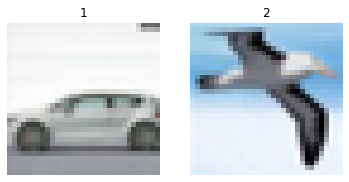

In [13]:
X_train = unpickle(input_path+dataset_name+"-train")
tryDataset(X_train)

### Conjunto de pruebas

Repetimos el mismo proceso para el conjunto de pruebas

(10000, 32, 32, 3)


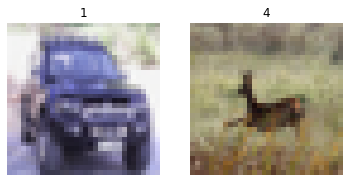

(10000, 32, 32, 3)


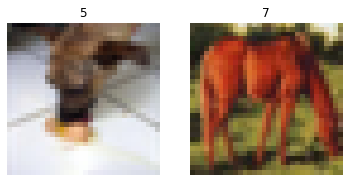

In [14]:
sample_from = unpickle("Input\cifar-10-batches-py\\test_batch")
X_test = {}
X_test["data"] = sample_from["data"].reshape(10000, 3, 32, 32)
X_test["labels"] = sample_from["labels"]
X_test["data"] = X_test["data"].transpose(0,2,3,1)
X_test["data"]=X_test["data"]/255
del sample_from
tryDataset(X_test)
saveDataset(X_test, "test")
X_test=unpickle(input_path+dataset_name+"-test")
tryDataset(X_test)